In [1]:
# importing libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf

In [19]:
#--------------------- Data Preprocessing --------------------#
# Importing and scaling the data
dataset_train = pd.read_csv("Google_Stock_Price_Trainset.csv")
#selecting the right column (we need all rows and column 1) : numpy array
training_set = dataset_train.iloc[:,1:2].values
print(training_set)
print(dataset_train.shape)
dataset_train.head()

[[ 743.      ]
 [ 746.450012]
 [ 730.      ]
 ...
 [1787.790039]
 [1762.01001 ]
 [1735.420044]]
(1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,1/4/16,743.000000,744.059998,731.257996,741.840027,741.840027,3272800
1,1/5/16,746.450012,752.000000,738.640015,742.580017,742.580017,1950700
2,1/6/16,730.000000,747.179993,728.919983,743.619995,743.619995,1947000
3,1/7/16,730.309998,738.500000,719.059998,726.390015,726.390015,2963700
4,1/8/16,731.450012,733.229980,713.000000,714.469971,714.469971,2450900


In [16]:
# Feature scaling
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled.size)
#print(training_set_scaled[0,:])

1259


In [20]:
#creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []

for i in range(90,training_set_scaled.size):
    # appending the 60 previous stock prices to the list for i
    # we need to specify the rows and simply pick the first and only column
    X_train.append(training_set_scaled[i-90:i, 0])
    # appending the 60th stock price to the list for i
    y_train.append(training_set_scaled[i, 0])
# transforming pandas lists to numpy arrays required for the RNN
X_train, y_train = np.array(X_train), np.array(y_train)
#print(X_train)


# Shaping/adding new dimensions to allow adding more indicators: from 2D to 3D
# 3 input arguments
# batch_size: number of observations
# timesteps: number of columns
# input_dim: number of predictors
X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1], 1])
#print(X_train)

In [6]:
#--------------------- Building RNN/LSTM model --------------------#
#Initializing the RNN

# independent variable is a sequence of layers: regression and no classification given the continuous output value
regressor = Sequential()
#------------------------------------------------------------------#
# Adding the first LSTM layer
#------------------------------------------------------------------#

# 3 inputs
# number of memory/LSTM units or neurons in each LSTM
# binary vb to indicate whether there will be further layers of LSTM added to teh model
# input shape (automatically takes teh first dimension so the reamining only needs to be specified)
print(X_train.shape[1])
regressor.add(LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], 1)))

# adding Dropout regularization layers
# 1 input: amount of neurons to ignore in the layers
regressor.add(Dropout(0.2))

#------------------------------------------------------------------#
# Adding the second LSTM layer
#------------------------------------------------------------------#
# no input shape needed given that that is specified in the previous layer
regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))

#------------------------------------------------------------------#
# Adding the third LSTM layer
#------------------------------------------------------------------#
regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))

#------------------------------------------------------------------#
# Adding the forth LSTM layer
#------------------------------------------------------------------#
regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))

#------------------------------------------------------------------#
# Adding the fifth LSTM layer
#------------------------------------------------------------------#
# note that this is the final LSTM layer, hence we change the binary argument to False
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#------------------------------------------------------------------#
# Adding output layer to the RNN to make a fully connected NN
#------------------------------------------------------------------#
# one dimensional real output
regressor.add(Dense(units = 1))

90


In [ ]:
#--------------------- Compiling the RNN model --------------------#
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

#--------------------- Training RNN model --------------------#
#connecting the built regressor to the training model
regressor.fit(X_train, y_train, epochs = 120, batch_size = 32)

In [8]:
#--------------------- Testing RNN model --------------------#
dataset_test = pd.read_csv("Google_Stock_Price_Testset.csv")
# actual stock prices
real_stock_price = dataset_test.iloc[:,1:2].values
# predicting the stock prices using X_test
# we need the original training data (vertical concatination 0, horizontal 1)
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
print(real_stock_price)

[[1757.540039]
 [1725.      ]
 [1702.630005]
 [1740.060059]
 [1787.97998 ]
 [1786.069946]
 [1753.920044]
 [1738.579956]
 [1753.619995]
 [1738.189941]
 [1752.25    ]
 [1831.459961]
 [1898.      ]
 [1895.680054]
 [1920.670044]
 [1888.839966]
 [1882.530029]
 [1843.939941]
 [1846.170044]
 [1853.569946]]


In [9]:
# for the consistence of the model we need to have the same scaling on the test as on the training
# for the first test day we need the previous 60 days data from train
print("First Financial day in 2021, when testing period begins",len(dataset_total)- len(dataset_test))
print("First Financial day in 2021 minus 60 days",len(dataset_total)- len(dataset_test) - 90)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 90:].values

# reshaping,normalizing the inputs
inputs = inputs.reshape(-1,1)
# no longer fitting but just transforming
inputs = sc.transform(inputs)

First Financial day in 2021, when testing period begins 1259
First Financial day in 2021 minus 60 days 1169


In [10]:
#storing test data as we did in teh training
X_test = []
for i in range(90,inputs.size):
    X_test.append(inputs[i-90:i, 0])
X_test = np.array(X_test)
#adding extra dimension
X_test = np.reshape(X_test, [X_test.shape[0], X_test.shape[1], 1])

#obtaining predicted values
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

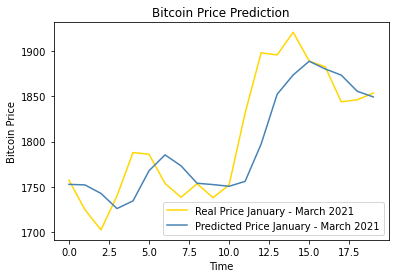

In [11]:
#--------------------- Visualizing the RNN model results--------------------#
plt.plot(real_stock_price, color = '#ffd700', label = "Real Price January - March 2021")
plt.plot(predicted_stock_price, color = '#4782B4', label = "Predicted Price January - March 2021")
plt.title("Bitcoin Price Prediction")
plt.xlabel("Time")
plt.ylabel("Bitcoin Price")
plt.legend()
plt.show()